# Battle of the Neighbourhoods - Finding an ideal holiday destination

## Project Description:

I decided to use this opportunity to analyse and understand which holiday destinations would suit us the best. 

### Description of the problem:
It's difficult to find the holiday spots that my wife and I can agree upon. As expected my wife always has the upper hand. Hopefully with this project I will search potential holiday destinations and score them for desirability based on our requirements. I will be searching for the top 100 attractions from centroid location in a city and assigning each a score. The scoring will be based on two key requirements: 
1. Has good city centre or what is available near city centre for a good cultural break that I like to have. 
2. Has a sea-side that my wife likes. 

### Methodology
First we'll identify 3 holiday destination coordinates using Geopy and our original tried and tested holiday destination, Devon, for comparison purposes:

In [1]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import warnings
warnings.filterwarnings('ignore')
address = 'Devon'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The geograpical coordinate of {} is {}, {}.'.format(address, latitude_x, longitude_y))


The geograpical coordinate of Devon is 50.75, -3.75.


In [2]:
import folium

In [60]:
m = folium.Map(
    location=[52.3745403, 4.89797550561798],
    zoom_start=5,
    tiles='Stamen Terrain'
)

folium.Marker(
    location=[55.6867243, 12.5700724],
    popup='Copenhagen',
    icon=folium.Icon(icon='flag')
).add_to(m)

folium.Marker(
    location=[48.85341, 2.3488],
    popup='Paris',
    icon=folium.Icon(color='green', icon='flag')
).add_to(m)

folium.Marker(
    location=[52.6843696, -1.8275286],
    popup='Home',
    icon=folium.Icon(color='red', icon='home')
).add_to(m)

folium.Marker(
    location=[52.3745403, 4.89797550561798],
    popup='Amsterdam',
    icon=folium.Icon(color='orange', icon='flag')
).add_to(m)

folium.Marker(
    location=[50.75, -3.75],
    popup='Devon',
    icon=folium.Icon(color='red', icon='heart')
).add_to(m)

m

### Next steps
I am going to use these coordinates in a Foursquare query to find venues for determining scores for each of these categories for my wife and me (D and S) and put these into a dataframe. 

Combine the data from Foursquare and the scores from the family to calculate the desirability of the 4 holiday destinations: Paris, Amsterdam, Copenhagen and Devon (control group). 

I will then use cluster analysis to ensure that both of us will enjoy the holiday by identifying the holiday destination that provide both sea-side and city break.

In [14]:
# find distinct venues in Paris as sample set
# perhaps filter for only hoilday relevant venues
# determine scoing from 4 parties 
# describe calcaultions
# plot locations based desirabilities back to map

Copenhagen_Coords =[55.6867243, 12.5700724]
Paris_Coords=[48.85341, 2.3488]
Amsterdam_Coords=[52.3745403, 4.89797550561798]
Devon_Coords=[50.725562, -3.5269108]

#### Import the libraries we're going to need:


In [15]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib as plt
import matplotlib.colors as colors

In [16]:
#Foursquare credentials 
CLIENT_ID = 'AGHDNWBAEWYOG5LQQILEJQREDLXZX3L23FY02ZXEY4VRCLTG'
CLIENT_SECRET = 'YJA1A1BECET22RATJKSQU014Y0LWHVHOQ433VXZFES1BGSQE'
VERSION = '20180605'


## First challenge - Filtering FourSquare results so that it only brings back results that are relevant

https://developer.foursquare.com/docs/api/venues/recommendations : By setting the 'intent' filter, we can only bring back venues of that category: food, breakfast, brunch, lunch, coffee, dinner, dessert, drinks, shopping, fun, sights. Specifies the top-level “intent” for a search.

For my holiday activities, I'm going to use 'fun'

In [17]:
intent = 'fun'
radius = 2000
LIMIT = 100

First we'll define a function to clean up the data received from FourSquare

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Then this function return the required data given a set of coordinates:

In [20]:
def get_holiday_fun(coords):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, coords[0], coords[1], radius, LIMIT,intent)
    results = requests.get(url).json()
    venues=results['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues)
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    return nearby_venues

I'll use my function 4 times to pull the information about 'fun' attractions in the potential holiday destinations

In [22]:
copenhagen_venues = get_holiday_fun(Copenhagen_Coords)
paris_venues = get_holiday_fun(Paris_Coords)
amsterdam_venues = get_holiday_fun(Amsterdam_Coords)
devon_venues = get_holiday_fun(Devon_Coords)

I now need a distinct list of attractions so that I can take these to my audience and ask them which is most important for our holiday. So I combine the datasets into one after having marked each with the city names:

In [23]:
# Combine Datasets
copenhagen_venues['City'] = 'Copenhagen'
paris_venues['City'] = 'Paris'
amsterdam_venues['City'] = 'Amsterdam'
devon_venues['City'] = 'Devon'
df = pd.concat([copenhagen_venues, paris_venues,amsterdam_venues,devon_venues])
df.columns = ['Name','Categories','Latitude','Longitude','City']

Using the .unique() function, I've found each type of attraction and written this to a CSV



In [24]:
categories = df.Categories.unique()

dataset = pd.DataFrame({'Categories':categories})

dataset.sort_values(by=['Categories'], ascending = True).to_csv(r'categories.csv')

I will use the scoring data in week 2 to score the venues and pick up the ideal holiday location for us

In [30]:
scoring = pd.DataFrame(pd.read_csv("categories.csv").to_dict(orient="row"))

scoring.head()

,Categories,Score
0,American Restaurant,5
1,Arcade,4
2,Art Gallery,3
3,Art Museum,6
4,Arts & Crafts Store,6


Next I join the scores to my dataframe with all the attractions:

In [31]:
df.head()

,Name,Categories,Latitude,Longitude,City
0,Rosenborg Slot,Palace,55.685683,12.577482,Copenhagen
1,Statens Museum for Kunst - SMK,Art Museum,55.688575,12.578399,Copenhagen
2,Kongens Have,Park,55.684361,12.580099,Copenhagen
3,Ørstedsparken,Park,55.680670,12.566367,Copenhagen
4,Nørrebro Teater,Theater,55.688039,12.561276,Copenhagen


In [32]:
df2 = pd.merge(df, scoring, how='left', on=['Categories','Categories'])

df2.head()

,Name,Categories,Latitude,Longitude,City,Score
0,Rosenborg Slot,Palace,55.685683,12.577482,Copenhagen,7
1,Statens Museum for Kunst - SMK,Art Museum,55.688575,12.578399,Copenhagen,6
2,Kongens Have,Park,55.684361,12.580099,Copenhagen,9
3,Ørstedsparken,Park,55.680670,12.566367,Copenhagen,9
4,Nørrebro Teater,Theater,55.688039,12.561276,Copenhagen,4


With this we have score for every venue to indicate its desirability

In [33]:
df2.groupby('City')['City'].value_counts()

City        City      
Amsterdam   Amsterdam     100
Copenhagen  Copenhagen    100
Devon       Devon          26
Paris       Paris         100
Name: City, dtype: int64

In [34]:
df2.groupby('City')['Score'].mean()

City
Amsterdam     6.000000
Copenhagen    6.520000
Devon         6.192308
Paris         5.860000
Name: Score, dtype: float64

## Conclusion 1: Copenhagen scores highest on average venue score!

Next I draw some charts to illustrate the relative merits of each holiday destination

In [35]:
import matplotlib.pyplot as plt

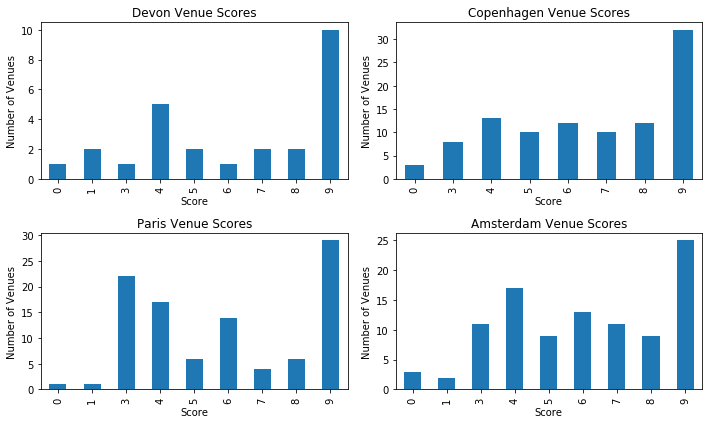

In [36]:
plt.subplot(2,2,1)

Devon_rows = df2['City'] == 'Devon'
Devon_venues = df2[Devon_rows]
Devon_venues.groupby('Score')['Score'].count().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Devon Venue Scores') # add title to the plot

plt.subplot(2,2,2)

Copenhagen_rows = df2['City'] == 'Copenhagen'
Copenhagen_venues = df2[Copenhagen_rows]
Copenhagen_venues.groupby('Score')['Score'].count().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Copenhagen Venue Scores') # add title to the plot

plt.subplot(2,2,3)

Paris_rows = df2['City'] == 'Paris'
Paris_venues = df2[Paris_rows]
Paris_venues.groupby('Score')['Score'].count().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Paris Venue Scores') # add title to the plot

plt.subplot(2,2,4)

Amsterdam_rows = df2['City'] == 'Amsterdam'
Amsterdam_venues = df2[Amsterdam_rows]
Amsterdam_venues.groupby('Score')['Score'].count().plot(kind='bar', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Amsterdam Venue Scores') # add title to the plot


plt.tight_layout()
plt.show()

Switching the above charts to pie

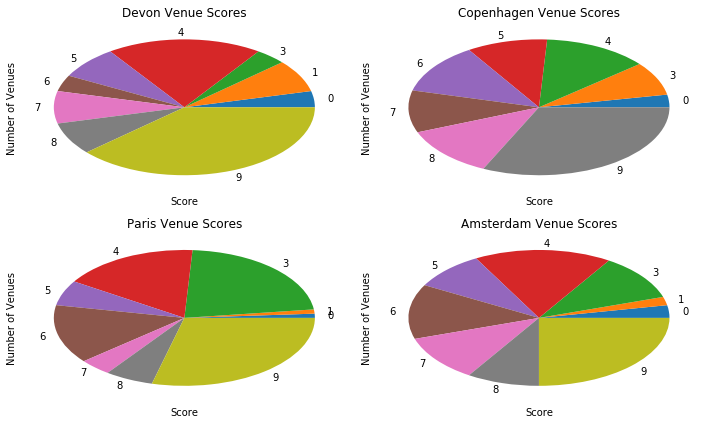

In [40]:
plt.subplot(2,2,1)

Devon_rows = df2['City'] == 'Devon'
Devon_venues = df2[Devon_rows]
Devon_venues.groupby('Score')['Score'].count().plot(kind='pie', figsize=(12, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Devon Venue Scores') # add title to the plot

plt.subplot(2,2,2)

Copenhagen_rows = df2['City'] == 'Copenhagen'
Copenhagen_venues = df2[Copenhagen_rows]
Copenhagen_venues.groupby('Score')['Score'].count().plot(kind='pie', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Copenhagen Venue Scores') # add title to the plot

plt.subplot(2,2,3)

Paris_rows = df2['City'] == 'Paris'
Paris_venues = df2[Paris_rows]
Paris_venues.groupby('Score')['Score'].count().plot(kind='pie', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Paris Venue Scores') # add title to the plot

plt.subplot(2,2,4)

Amsterdam_rows = df2['City'] == 'Amsterdam'
Amsterdam_venues = df2[Amsterdam_rows]
Amsterdam_venues.groupby('Score')['Score'].count().plot(kind='pie', figsize=(10, 6))

plt.xlabel('Score') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Amsterdam Venue Scores') # add title to the plot


plt.tight_layout()
plt.show()

In [41]:
colour = ['white','grey','lightblue','lightblue','blue','orange','orange','green','green','green','green']

In [45]:
devon = folium.Map(
    location=Devon_Coords,
    zoom_start=13,
    tiles='Stamen Terrain'
)

copenhagen = folium.Map(
    location=Copenhagen_Coords,
    zoom_start=13,
    tiles='Stamen Terrain'
)

paris = folium.Map(
    location=Paris_Coords,
    zoom_start=13,
    tiles='Stamen Terrain'
)

amsterdam = folium.Map(
    location=Amsterdam_Coords,
    zoom_start=13,
    tiles='Stamen Terrain'
)

In [46]:
def plot_venue(city,latitude,longitude,category,color):
    folium.Marker(location=[latitude, longitude],popup=category,icon=folium.Icon(color=color, icon='flag')
                ).add_to(city)

In [47]:
for index, row in df2.iterrows():
    if (row['City'] == 'Devon'):
        plot_venue(devon,row['Latitude'],row['Longitude'],row['Categories'],colour[int(row['Score'])])
        
for index, row in df2.iterrows():
    if (row['City'] == 'Copenhagen'):
        plot_venue(copenhagen,row['Latitude'],row['Longitude'],row['Categories'],colour[int(row['Score'])])

for index, row in df2.iterrows():
    if (row['City'] == 'Paris'):
        plot_venue(paris,row['Latitude'],row['Longitude'],row['Categories'],colour[int(row['Score'])])
       
for index, row in df2.iterrows():
    if (row['City'] == 'Amsterdam'):
        plot_venue(amsterdam,row['Latitude'],row['Longitude'],row['Categories'],colour[int(row['Score'])])

In [64]:
copenhagen

In [63]:
devon

In [52]:
paris

In [53]:
amsterdam

In [54]:

# one hot encoding
df_onehot = pd.get_dummies(df2[['Categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['City'] = df2['City']

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_grouped = df_onehot.groupby('City').mean().reset_index()
df_grouped

,City,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Bar,Boat or Ferry,Bookstore,Bowling Alley,Cafeteria,Café,Cemetery,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convention Center,Cultural Center,Dive Bar,French Restaurant,Garden,Government Building,Historic Site,History Museum,Hotel Bar,Indie Movie Theater,Indie Theater,Jazz Club,Library,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Opera House,Outdoor Sculpture,Palace,Park,Performing Arts Venue,Piano Bar,Plaza,Pool Hall,Pub,Rock Club,Salon / Barbershop,Scandinavian Restaurant,Scenic Lookout,Science Museum,Soccer Stadium,Stadium,Tattoo Parlor,Theater,Theme Park,Theme Park Ride / Attraction,University,Zoo,Zoo Exhibit
0,Amsterdam,0.00,0.03,0.090000,0.07,0.00,0.040000,0.01,0.00,0.000000,0.00,0.000000,0.00,0.02,0.00,0.01,0.00,0.01,0.02,0.00,0.00,0.01,0.00,0.00,0.00,0.020000,0.04,0.00,0.030000,0.02,0.02,0.01,0.00,0.050000,0.010000,0.130000,0.050000,0.00,0.01,0.020000,0.01,0.010000,0.02,0.00,0.02,0.02,0.010000,0.000000,0.01,0.00,0.01,0.03,0.000000,0.00,0.01,0.070000,0.00,0.03,0.00,0.01,0.02
1,Copenhagen,0.01,0.00,0.070000,0.05,0.01,0.040000,0.00,0.00,0.010000,0.01,0.010000,0.01,0.00,0.00,0.00,0.00,0.00,0.04,0.02,0.00,0.00,0.00,0.02,0.00,0.020000,0.05,0.00,0.020000,0.00,0.02,0.01,0.01,0.040000,0.010000,0.020000,0.050000,0.01,0.01,0.000000,0.01,0.140000,0.01,0.00,0.02,0.00,0.000000,0.010000,0.01,0.01,0.00,0.02,0.030000,0.01,0.00,0.100000,0.03,0.02,0.01,0.00,0.00
2,Devon,0.00,0.00,0.038462,0.00,0.00,0.076923,0.00,0.00,0.038462,0.00,0.038462,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.038462,0.00,0.00,0.038462,0.00,0.00,0.00,0.00,0.038462,0.038462,0.076923,0.038462,0.00,0.00,0.038462,0.00,0.192308,0.00,0.00,0.00,0.00,0.076923,0.038462,0.00,0.00,0.00,0.00,0.076923,0.00,0.00,0.115385,0.00,0.00,0.00,0.00,0.00
3,Paris,0.00,0.00,0.170000,0.09,0.00,0.000000,0.00,0.01,0.000000,0.00,0.000000,0.00,0.03,0.01,0.00,0.01,0.01,0.01,0.00,0.03,0.00,0.01,0.01,0.01,0.130000,0.01,0.01,0.100000,0.00,0.05,0.00,0.01,0.010000,0.000000,0.070000,0.000000,0.00,0.01,0.000000,0.00,0.070000,0.00,0.01,0.01,0.00,0.010000,0.000000,0.00,0.00,0.00,0.03,0.000000,0.00,0.00,0.060000,0.00,0.00,0.00,0.01,0.00


In [57]:
df_grouped.shape

(4, 61)

In [58]:
num_top_venues = 5

for hood in df_grouped['City']:
    print("----"+hood+"----")
    temp = df_grouped[df_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amsterdam----
           venue  freq
0         Museum  0.13
1    Art Gallery  0.09
2     Art Museum  0.07
3        Theater  0.07
4  Movie Theater  0.05


----Copenhagen----
         venue  freq
0         Park  0.14
1      Theater  0.10
2  Art Gallery  0.07
3  Music Venue  0.05
4   Art Museum  0.05


----Devon----
     venue  freq
0     Park  0.19
1  Theater  0.12
2      Pub  0.08
3   Museum  0.08
4      Bar  0.08


----Paris----
                 venue  freq
0          Art Gallery  0.17
1        Historic Site  0.13
2  Indie Movie Theater  0.10
3           Art Museum  0.09
4                 Park  0.07




## Conclusions
Using the above analysis, I discovered Copenhagen scores highly based on our interest. Who would have thought that Copenhagen suits anyone better than Paris! Not me. 

All of the cities have something to offer to us that suits our holiday requirements. Copenhagen has the most. Interestingly, Copenhagen does not have more venues than the others. It has more average attraction venues based on our scores. 

All in all, Copenhagen wins! We will plan our holiday to Copenhagen to check whether my analysis is right or not! If it is then we have found an amazing holiday planner for us - Python!